In [139]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw

In [140]:
with open('sample_score-2.svg') as f:
    soup = BeautifulSoup(f, 'xml')
    
svg_tag = soup.find('svg')
width = float(svg_tag['width'].strip('px'))
height = float(svg_tag['height'].strip('px'))
    
image = Image.open('sample_score-2.png')
image_width, image_height = image.width, image.height

In [141]:
staff_line_tags = [x for x in soup.find_all('polyline') if x['class'] == 'StaffLines']

In [142]:
staff_line_heights = [float(x['points'].split()[0].split(',')[1]) for x in staff_line_tags]

In [143]:
def get_coords(s):
    # s is a string like M425.006,618.084
    # returns a pair of floats (425.006, 618.084)
    x = s.split()
    x = [y.strip('MCL') for y in x]
    x = np.array(list(map(lambda y: list(map(float, y.split(','))), x)))
    return x

In [144]:
text_tags = [x for x in soup.find_all('path') if x['class'] == 'Text']
if text_tags:
    text_tag = text_tags[0]
    text_coords = get_coords(text_tag['d'])
    text_y_coords = [x[1] for x in text_coords]
    text_bottom_height = np.max(text_y_coords)
    first_height = text_bottom_height
else:
    first_height = 0

In [145]:

print(text_bottom_height)

249.889


In [146]:
print(staff_line_heights)

[317.607, 342.607, 367.608, 392.608, 417.608, 580.108, 605.108, 630.108, 655.108, 680.108, 916.598, 941.598, 966.598, 991.598, 1016.6, 1206.47, 1231.47, 1256.47, 1281.47, 1306.47, 1542.96, 1567.96, 1592.96, 1617.96, 1642.96, 1805.46, 1830.46, 1855.46, 1880.46, 1905.46, 2141.95, 2166.95, 2191.95, 2216.95, 2241.95, 2453.0, 2478.0, 2503.0, 2528.0, 2553.0, 2789.49, 2814.49, 2839.49, 2864.49, 2889.49, 3051.99, 3076.99, 3101.99, 3126.99, 3151.99, 3388.48, 3413.48, 3438.48, 3463.48, 3488.48, 3650.98, 3675.98, 3700.98, 3725.98, 3750.98]


In [147]:
last_height = (staff_line_heights[-1] + height)/2

In [148]:
midpoints = [first_height]
for i in range((len(staff_line_heights) // 10)-1):
    top = staff_line_heights[10*i + 9]
    bottom = staff_line_heights[10*i + 10]
    midpoints.append((top + bottom) / 2)
midpoints.append(last_height)

In [149]:
horizontal_fracs = [x/height for x in midpoints]

In [150]:
time_sigs = [x for x in soup.find_all('path') if x['class'] == 'TimeSig']
if time_sigs:
    time_sig_coords = np.concatenate([get_coords(x['d']) for x in time_sigs], axis=0)
    time_sig_max = np.max(time_sig_coords[:, 0])
    time_sig_max_frac = time_sig_max/width
else:
    time_sig_max_frac = None

key_sigs = [x for x in soup.find_all('path') if x['class'] == 'KeySig']
if key_sigs:
    key_sig_coords = np.concatenate([get_coords(x['d']) for x in key_sigs], axis=0)
    key_sig_max = np.max(key_sig_coords[:, 0])
    key_sig_max_frac = key_sig_max/width
else:
    key_sig_max_frac = None
    
clefs = [x for x in soup.find_all('path') if x['class'] == 'Clef']
clef_coords = np.concatenate([get_coords(x['d']) for x in clefs], axis=0)
clef_max = np.max(clef_coords[:, 0])
clef_max_frac = clef_max/width


barlines = [x for x in soup.find_all('polyline') if x['class'] == 'BarLine']
def get_barline_fracs(barline):
    # returns a, b, c where a is the horizontal fraction for the barline and b and c are the top and bottom vertical fractions
    barline_string = barline['points']
    x = barline_string.split()
    y = (list(map(float, x[0].split(','))), list(map(float, x[1].split(','))))
    a = y[0][0]/width
    b = y[0][1]/height
    c = y[1][1]/height
    return a, b, c

def get_barlines_within_region(h1, h2):
    # gets the x coordinates corresponding to barlines whose top and bottom are between h1 and h2
    regional_x_coords = []
    for barline in barlines:
        a, b, c = get_barline_fracs(barline)
        if h1 < b <h2 and h1 < c <h2:
            regional_x_coords.append(a)
    return regional_x_coords

sets_of_regional_x_coords = []
for i in range(len(horizontal_fracs)-1):
    h1 = horizontal_fracs[i]
    h2 = horizontal_fracs[i+1]
    regional_x_coords = get_barlines_within_region(h1, h2)
    # handle duplicates of barlines from the two staves
    regional_x_coords = sorted(set(regional_x_coords))
    # handle the case of double barline at the end of the piece
    if len(regional_x_coords) >= 3 and np.abs(regional_x_coords[-1] - regional_x_coords[-2]) < 0.01:
        regional_x_coords = regional_x_coords[:-2]
    sets_of_regional_x_coords.append(regional_x_coords)

In [151]:
bboxes = []
for i in range(len(horizontal_fracs)-1):
    h1 = horizontal_fracs[i]
    h2 = horizontal_fracs[i+1]
    x_coords = sets_of_regional_x_coords[i]
    if i == 0 and time_sig_max_frac:
        x_coords[0] = time_sig_max_frac
    elif key_sig_max_frac:
        x_coords[0] = key_sig_max_frac
    else:
        x_coords[0] = clef_max_frac
    regional_bboxes = []
    for j in range(len(x_coords)-1):
        regional_bboxes.append(((x_coords[j]*image_width, h1*image_height), (x_coords[j+1]*image_width, h2*image_height)))
    bboxes.append(regional_bboxes)

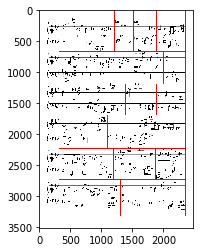

In [152]:
draw = ImageDraw.Draw(image)
for region in bboxes:
    for bbox in region:
        draw.rectangle(bbox, outline='red', width=5)
image_np = np.array(image)
plt.imshow(image_np, cmap='bone_r')
processed_image = Image.fromarray(image_np)
processed_image.save('saved_image.png')